In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
import soundfile as sf
#import sounddevice as sd 
import torch.optim as optim
import IPython.display as ipd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
#from transformers import Speech2TextProcessor, Speech2TextForSequenceClassification
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor 

In [2]:
dataset_dir = '/kaggle/input/tamil-hate-speech'
hate_dir = os.path.join(dataset_dir, 'Hate')
non_hate_dir = os.path.join(dataset_dir, 'Non Hate')

In [3]:
# Initialize an empty list to store the file information
data = []

# Iterate through the "Hate" and "Non Hate" folders
for label in ["Hate", "Non Hate"]:
    folder_path = os.path.join(dataset_dir, label)
    
    # For "Hate" category, also iterate through the subfolders
    if label == "Hate":
        for sub_category in ["Character Assassination", "Gender", "Political", "Religion"]:
            sub_folder_path = os.path.join(folder_path, sub_category)
            for file_name in os.listdir(sub_folder_path):
                # Parse details from the file name
                parts = file_name.split('_')
                hate_or_non_hate = "Hate"
                sub_category_code = parts[3]  # e.g., C, G, P, or R
                gender = parts[4]
                
                # Store details in a dictionary
                file_info = {
                    "File Name": file_name,
                    "Hate or Non Hate": hate_or_non_hate,
                    "Sub Category": sub_category_code,
                    "Gender": gender,
                    "File Path": os.path.join(sub_folder_path, file_name)
                }
                data.append(file_info)
    else:
        # For "Non Hate" files, only iterate through the files directly
        for file_name in os.listdir(folder_path):
            parts = file_name.split('_')
            hate_or_non_hate = "Non Hate"
            sub_category_code = "NH"  # No sub-category for non-hate files
            gender = parts[4]
            
            # Store details in a dictionary
            file_info = {
                "File Name": file_name,
                "Hate or Non Hate": hate_or_non_hate,
                "Sub Category": sub_category_code,
                "Gender": gender,
                "File Path": os.path.join(folder_path, file_name)
            }
            data.append(file_info)

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

In [4]:
df

,File Name,Hate or Non Hate,Sub Category,Gender,File Path
0,H_TA_002_C_F_005_002.wav,Hate,C,F,/kaggle/input/tamil-hate-speech/Hate/Character...
1,H_TA_003_C_M_004_002.wav,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...
2,H_TA_003_C_M_007_003.wav,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...
3,H_TA_001_C_M_003_002.mp3,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...
4,H_TA_002_C_F_005_001.wav,Hate,C,F,/kaggle/input/tamil-hate-speech/Hate/Character...
...,...,...,...,...,...
555,NH_TA_002_N_M_014_015.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...
556,NH_TA_003_N_F_023_001.wav,Non Hate,NH,F,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...
557,NH_TA_003_N_M_060_002.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...
558,NH_TA_002_N_M_013_018.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...


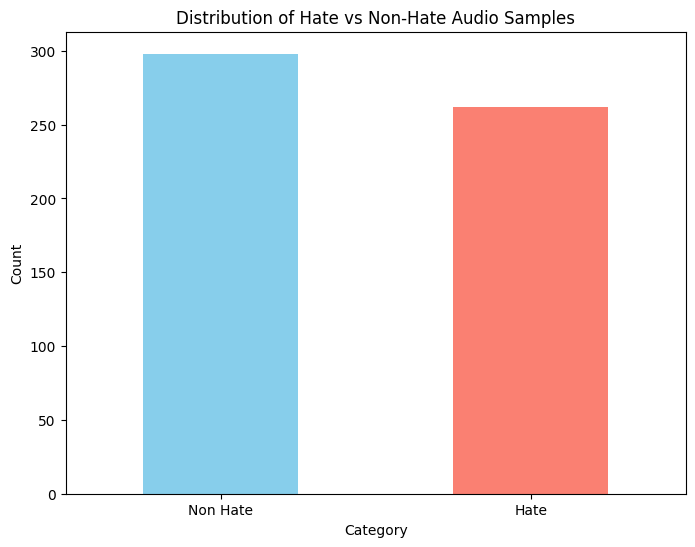

In [5]:
# Get the count of each category (Hate vs Non Hate)
hate_non_hate_counts = df["Hate or Non Hate"].value_counts()

# Plot the distribution as a bar graph
plt.figure(figsize=(8, 6))
hate_non_hate_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Hate vs Non-Hate Audio Samples')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

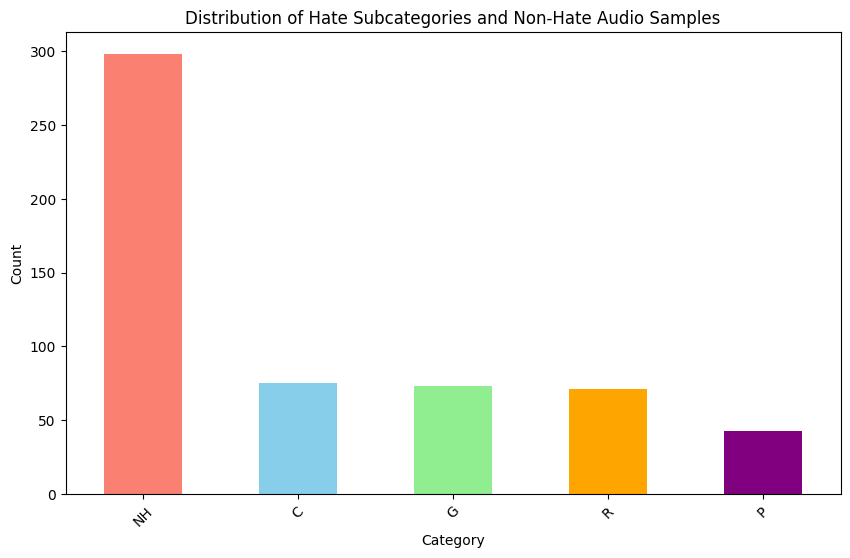

In [6]:
# Replace NaN in "Sub Category" with "Non Hate" for easier grouping
df['Sub Category'] = df['Sub Category'].fillna('Non Hate')

# Get the count of each subcategory (including Non Hate)
subcategory_counts = df['Sub Category'].value_counts()

# Plot the distribution as a bar graph
plt.figure(figsize=(10, 6))
subcategory_counts.plot(kind='bar', color=['salmon', 'skyblue', 'lightgreen', 'orange', 'purple'])
plt.title('Distribution of Hate Subcategories and Non-Hate Audio Samples')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [7]:
def get_audio_duration(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=audio, sr=sr)

df['Duration'] = df['File Path'].apply(get_audio_duration)

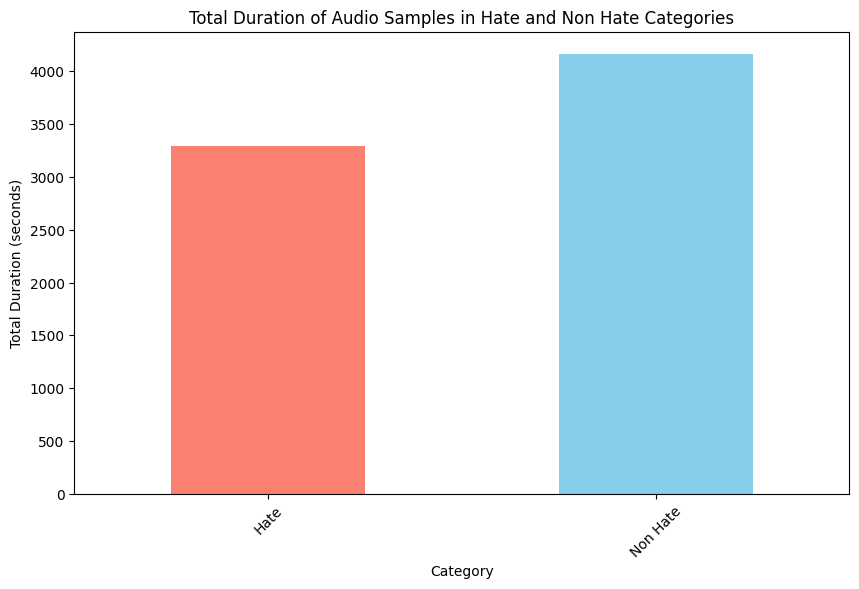

In [8]:
total_durations_HateorNonHate = df.groupby('Hate or Non Hate')['Duration'].sum()
                                                                                
# Plot the total duration for each category
plt.figure(figsize=(10, 6))
total_durations_HateorNonHate.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Total Duration of Audio Samples in Hate and Non Hate Categories')
plt.xlabel('Category')
plt.ylabel('Total Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

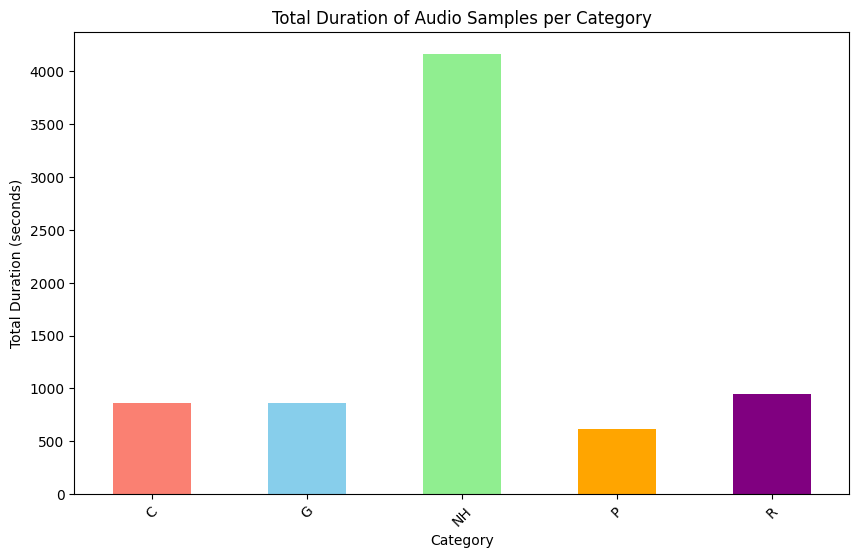

In [9]:
total_durations_per_category = df.groupby('Sub Category')['Duration'].sum()
                                                                                
# Plot the total duration for each category
plt.figure(figsize=(10, 6))
total_durations_per_category.plot(kind='bar', color=['salmon', 'skyblue', 'lightgreen', 'orange', 'purple'])
plt.title('Total Duration of Audio Samples per Category')
plt.xlabel('Category')
plt.ylabel('Total Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

In [10]:
def copy_and_resample_audio(df, input_dir, output_dir, target_sr=16000):
    
    os.makedirs(output_dir, exist_ok=True)
    resampled_rates = []
    new_file_paths = []

    for index, row in df.iterrows():
        # Get the original file path
        original_file_path = row['File Path']
        
        # Determine the relative path to maintain the structure
        relative_path = os.path.relpath(original_file_path, input_dir)
        new_file_path = os.path.join(output_dir, relative_path)

        # Create necessary directories for the new file path
        os.makedirs(os.path.dirname(new_file_path), exist_ok=True)

        # Load the original audio file
        original_audio, sr_original = librosa.load(original_file_path, sr=None)

        # Resample the audio
        resampled_audio = librosa.resample(original_audio, orig_sr=sr_original, target_sr=target_sr)

        # Save the resampled audio to the new file path as .mp3
        sf.write(new_file_path, resampled_audio, target_sr, format='MP3')

        # Append the new sampling rate and new file path to their respective lists
        resampled_rates.append(target_sr)
        new_file_paths.append(new_file_path)  # Keep it in .mp3 format

    # Add the new columns to the DataFrame
    df['Resampled Sampling Rate'] = resampled_rates
    df['New File Path'] = new_file_paths
    
    return df

input_directory = '/kaggle/input/telugu-hate-speech'
output_directory = '/kaggle/working/resampled_audios'

new_df = copy_and_resample_audio(df, input_directory, output_directory)

In [11]:
new_df

,File Name,Hate or Non Hate,Sub Category,Gender,File Path,Duration,Resampled Sampling Rate,New File Path
0,H_TA_002_C_F_005_002.wav,Hate,C,F,/kaggle/input/tamil-hate-speech/Hate/Character...,6.493855,16000,/kaggle/working/resampled_audios/../tamil-hate...
1,H_TA_003_C_M_004_002.wav,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...,8.428844,16000,/kaggle/working/resampled_audios/../tamil-hate...
2,H_TA_003_C_M_007_003.wav,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...,7.755465,16000,/kaggle/working/resampled_audios/../tamil-hate...
3,H_TA_001_C_M_003_002.mp3,Hate,C,M,/kaggle/input/tamil-hate-speech/Hate/Character...,10.005964,16000,/kaggle/working/resampled_audios/../tamil-hate...
4,H_TA_002_C_F_005_001.wav,Hate,C,F,/kaggle/input/tamil-hate-speech/Hate/Character...,4.127891,16000,/kaggle/working/resampled_audios/../tamil-hate...
...,...,...,...,...,...,...,...,...
555,NH_TA_002_N_M_014_015.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...,5.905896,16000,/kaggle/working/resampled_audios/../tamil-hate...
556,NH_TA_003_N_F_023_001.wav,Non Hate,NH,F,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...,18.993923,16000,/kaggle/working/resampled_audios/../tamil-hate...
557,NH_TA_003_N_M_060_002.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...,17.600726,16000,/kaggle/working/resampled_audios/../tamil-hate...
558,NH_TA_002_N_M_013_018.wav,Non Hate,NH,M,/kaggle/input/tamil-hate-speech/Non Hate/NH_TA...,10.480750,16000,/kaggle/working/resampled_audios/../tamil-hate...


In [12]:
new_df.to_csv('preprocessed_data.csv', index=False)
print(new_df.columns.tolist())

['File Name', 'Hate or Non Hate', 'Sub Category', 'Gender', 'File Path', 'Duration', 'Resampled Sampling Rate', 'New File Path']


In [13]:
# Splitting the dataset into training and testing sets
X = new_df[['File Name', 'New File Path', 'Duration']]
y = new_df[['Hate or Non Hate', 'Sub Category']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
y_train['Sub Category'].value_counts()

Sub Category
NH    244
C      61
R      60
G      50
P      33
Name: count, dtype: int64

In [15]:
y_test['Sub Category'].value_counts()

Sub Category
NH    54
G     23
C     14
R     11
P     10
Name: count, dtype: int64

In [16]:
print(f"Number of TRAINING samples: {len(X_train)}")
print(f"Number of TEST samples: {len(X_test)}")

Number of TRAINING samples: 448
Number of TEST samples: 112


In [17]:
# Adding binary and multi-class classification labels to X_train and X_test
# Binary label: 'Hate or Non Hate' as 0 (Non Hate) or 1 (Hate) 
X_train['Binary Label'] = y_train['Hate or Non Hate'].apply(lambda x: 1 if x == 'Hate' else 0)
X_test['Binary Label'] = y_test['Hate or Non Hate'].apply(lambda x: 1 if x == 'Hate' else 0)

# Multi-class label: 'Sub Category' with unique numeric encoding for each category
# Assigning numeric labels to each sub-category for multi-class classification
category_mapping = {category: i for i, category in enumerate(y['Sub Category'].unique())}
X_train['Multi-class Label'] = y_train['Sub Category'].map(category_mapping)
X_test['Multi-class Label'] = y_test['Sub Category'].map(category_mapping)

In [18]:
category_mapping

{'C': 0, 'G': 1, 'P': 2, 'R': 3, 'NH': 4}

In [19]:
# Shuffle the training set before saving
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
X_train.to_csv('train_data.csv', index=False)

# Shuffle the testing set before saving
X_test = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
X_test.to_csv('test_data.csv', index=False)

In [20]:
data_files = {
    "train": "/kaggle/working/train_data.csv",
    "test": "/kaggle/working/test_data.csv",
}

dataset = load_dataset("csv", data_files=data_files)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Print the loaded datasets
print(train_dataset)
print(test_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['File Name', 'New File Path', 'Duration', 'Binary Label', 'Multi-class Label'],
    num_rows: 448
})
Dataset({
    features: ['File Name', 'New File Path', 'Duration', 'Binary Label', 'Multi-class Label'],
    num_rows: 112
})


In [21]:
input_column = 'New File Path'
output_column_B = 'Binary Label'
output_column_M = 'Multi-class Label'

# we need to distinguish the unique labels in our SER dataset
binary_label_list = train_dataset.unique(output_column_B)
binary_label_list.sort()  # Let's sort it for determinism
num_labels_B = len(binary_label_list)


# we need to distinguish the unique labels in our SER dataset
multi_class_label_list = train_dataset.unique(output_column_M)
multi_class_label_list.sort()  # Let's sort it for determinism
num_labels_M = len(multi_class_label_list)

print(f"A binary classification problem with {num_labels_B} classes: {binary_label_list}")
print(f"A multi-class classification problem with {num_labels_M} classes: {multi_class_label_list}")

A binary classification problem with 2 classes: [0, 1]
A multi-class classification problem with 5 classes: [0, 1, 2, 3, 4]


# **Wav2Vec2-XLSR**

In [22]:
model_name = "facebook/wav2vec2-xls-r-300m"

# Load the pre-trained Wav2Vec 2.0 XLSR feature extractor and model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)
 
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model details
print(model)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [23]:
# Update model configuration to set pooling mode and use binary labels
pooling_mode = "mean"  # Using mean pooling for downsampling hidden states
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels_B,
    label2id={label: i for i, label in enumerate(binary_label_list)},
    id2label={i: label for i, label in enumerate(binary_label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [24]:
# Load and resample audio to 16,000 Hz
def load_and_resample_audio(filepath, target_sampling_rate=16000):
    speech_array, sampling_rate = torchaudio.load(filepath)
    if sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
        speech_array = resampler(speech_array)
    return speech_array.squeeze().numpy()

# Feature extraction with mean pooling (Runs on GPU)
def extract_features_from_audio(filepath):
    speech_array = load_and_resample_audio(filepath, target_sampling_rate=target_sampling_rate)

    # Convert audio to tensor and move to GPU
    inputs = feature_extractor(speech_array, sampling_rate=target_sampling_rate, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to GPU

    with torch.no_grad():  # Disable gradient computation
        outputs = model(**inputs)

    hidden_states = outputs.last_hidden_state
    pooled_features = hidden_states.mean(dim=1) if pooling_mode == 'mean' else hidden_states  # Apply mean pooling

    return pooled_features.cpu()  # Move back to CPU before returning

# Extract features for train and test datasets (Runs on GPU)
def extract_and_save_features(dataset, filename):
    all_features = [extract_features_from_audio(example['New File Path']).numpy() for example in dataset]
    concatenated_features = np.concatenate(all_features, axis=0)
    np.save(filename, concatenated_features)
    return concatenated_features

In [25]:
# Run feature extraction on GPU
train_features_wav2vec2 = extract_and_save_features(train_dataset, 'wav2vec2_xlsr_train_features.npy')
print(train_features_wav2vec2.shape)

(448, 1024)


In [26]:
test_features_wav2vec2 = extract_and_save_features(test_dataset, 'wav2vec2_xlsr_test_features.npy')
print(test_features_wav2vec2.shape)

(112, 1024)


In [27]:
'''# Load train and test features 
train_features_wav2vec2 = np.load('/kaggle/input/wav2vec2-tamil/wav2vec2_xlsr_train_features.npy')
print(train_features_wav2vec2.shape) 
test_features_wav2vec2 = np.load('/kaggle/input/wav2vec2-tamil/wav2vec2_xlsr_test_features.npy')
print(test_features_wav2vec2.shape)'''

"# Load train and test features \ntrain_features_wav2vec2 = np.load('/kaggle/input/wav2vec2-tamil/wav2vec2_xlsr_train_features.npy')\nprint(train_features_wav2vec2.shape) \ntest_features_wav2vec2 = np.load('/kaggle/input/wav2vec2-tamil/wav2vec2_xlsr_test_features.npy')\nprint(test_features_wav2vec2.shape)"

In [28]:
# Prepare data tensors
def prepare_data(features, labels, num_samples, sequence_length, feature_size):
    # Reshape features into (num_samples, sequence_length, feature_size)
    features = features.reshape(num_samples, sequence_length, feature_size)
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return features_tensor, labels_tensor
 
# Run with updated function 
train_labels_bin = np.array([0 if example['Binary Label'] == 0 else 1 for example in train_dataset])
test_labels_bin = np.array([0 if example['Binary Label'] == 0 else 1 for example in test_dataset])

train_features_xlsr, train_labels_tensor_xlsr_bin = prepare_data(train_features_wav2vec2, train_labels_bin, 448, 1, 1024)
test_features_xlsr, test_labels_tensor_xlsr_bin = prepare_data(test_features_wav2vec2, test_labels_bin, 112, 1, 1024)

In [29]:
print(f"Shape of training features: {train_features_xlsr.shape}")
print(f"Number of training labels: {len(train_labels_tensor_xlsr_bin)}")

print(f"Shape of testing features: {test_features_xlsr.shape}")
print(f"Number of testing labels: {len(test_labels_tensor_xlsr_bin)}")

Shape of training features: torch.Size([448, 1, 1024])
Number of training labels: 448
Shape of testing features: torch.Size([112, 1, 1024])
Number of testing labels: 112


In [30]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cuda


In [103]:
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # Progress bar
from torch.utils.data import DataLoader, TensorDataset

# Define the LSTM model
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1024
hidden_size = 128
num_layers = 2
num_classes = 2
learning_rate = 0.002
num_epochs = 20
batch_size = 16

In [104]:
# Convert data to GPU
train_features_xlsr, train_labels_tensor_xlsr_bin = train_features_xlsr.to(device), train_labels_tensor_xlsr_bin.to(device)
test_features_xlsr, test_labels_tensor_xlsr_bin = test_features_xlsr.to(device), test_labels_tensor_xlsr_bin.to(device)
 
# Create DataLoader for batching
train_dataset_xlsr_bin = TensorDataset(train_features_xlsr, train_labels_tensor_xlsr_bin)
train_loader = DataLoader(train_dataset_xlsr_bin, batch_size=batch_size, shuffle=True) 

In [107]:
# Model, Loss, Optimizer
model_1 = AudioLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_1, train_loader, optimizer, criterion, num_epochs)

Epoch 1/20: 100%|██████████| 28/28 [00:00<00:00, 211.57batch/s, Batch Loss=0.694]


Epoch [1/20], Average Loss: 0.6916


Epoch 2/20: 100%|██████████| 28/28 [00:00<00:00, 208.10batch/s, Batch Loss=0.798]


Epoch [2/20], Average Loss: 0.6867


Epoch 3/20: 100%|██████████| 28/28 [00:00<00:00, 207.52batch/s, Batch Loss=0.667]


Epoch [3/20], Average Loss: 0.6791


Epoch 4/20: 100%|██████████| 28/28 [00:00<00:00, 207.96batch/s, Batch Loss=0.577]


Epoch [4/20], Average Loss: 0.6585


Epoch 5/20: 100%|██████████| 28/28 [00:00<00:00, 204.08batch/s, Batch Loss=0.778]


Epoch [5/20], Average Loss: 0.6398


Epoch 6/20: 100%|██████████| 28/28 [00:00<00:00, 209.83batch/s, Batch Loss=0.707]


Epoch [6/20], Average Loss: 0.6689


Epoch 7/20: 100%|██████████| 28/28 [00:00<00:00, 208.80batch/s, Batch Loss=0.595]


Epoch [7/20], Average Loss: 0.6480


Epoch 8/20: 100%|██████████| 28/28 [00:00<00:00, 212.01batch/s, Batch Loss=0.583]


Epoch [8/20], Average Loss: 0.6002


Epoch 9/20: 100%|██████████| 28/28 [00:00<00:00, 211.67batch/s, Batch Loss=0.652]


Epoch [9/20], Average Loss: 0.5858


Epoch 10/20: 100%|██████████| 28/28 [00:00<00:00, 212.81batch/s, Batch Loss=1.33] 


Epoch [10/20], Average Loss: 0.6190


Epoch 11/20: 100%|██████████| 28/28 [00:00<00:00, 211.08batch/s, Batch Loss=0.54] 


Epoch [11/20], Average Loss: 0.6074


Epoch 12/20: 100%|██████████| 28/28 [00:00<00:00, 212.52batch/s, Batch Loss=0.794]


Epoch [12/20], Average Loss: 0.5563


Epoch 13/20: 100%|██████████| 28/28 [00:00<00:00, 207.24batch/s, Batch Loss=0.387]


Epoch [13/20], Average Loss: 0.5225


Epoch 14/20: 100%|██████████| 28/28 [00:00<00:00, 207.24batch/s, Batch Loss=0.717]


Epoch [14/20], Average Loss: 0.5263


Epoch 15/20: 100%|██████████| 28/28 [00:00<00:00, 206.87batch/s, Batch Loss=0.673]


Epoch [15/20], Average Loss: 0.5283


Epoch 16/20: 100%|██████████| 28/28 [00:00<00:00, 209.62batch/s, Batch Loss=0.602]


Epoch [16/20], Average Loss: 0.5476


Epoch 17/20: 100%|██████████| 28/28 [00:00<00:00, 210.59batch/s, Batch Loss=0.454]


Epoch [17/20], Average Loss: 0.4838


Epoch 18/20: 100%|██████████| 28/28 [00:00<00:00, 212.89batch/s, Batch Loss=0.52] 


Epoch [18/20], Average Loss: 0.4784


Epoch 19/20: 100%|██████████| 28/28 [00:00<00:00, 207.12batch/s, Batch Loss=0.654]


Epoch [19/20], Average Loss: 0.4491


Epoch 20/20: 100%|██████████| 28/28 [00:00<00:00, 206.45batch/s, Batch Loss=0.516]

Epoch [20/20], Average Loss: 0.4406


              precision    recall  f1-score   support

    Non-Hate       0.77      0.80      0.78        54
        Hate       0.80      0.78      0.79        58

    accuracy                           0.79       112
   macro avg       0.79      0.79      0.79       112
weighted avg       0.79      0.79      0.79       112



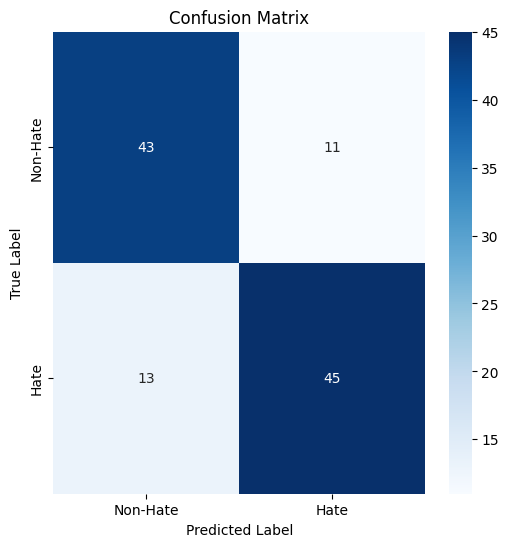

In [108]:
import seaborn as sns
 
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval() 
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['Non-Hate', 'Hate']))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        
# Testing
evaluate_model(model_1, test_features_xlsr, test_labels_tensor_xlsr_bin)

In [109]:
# Save the trained model
torch.save(model_1.state_dict(), "wav2vec2_bin_lstm_model (TAMIL).pth")
print("Model saved successfully!")

Model saved successfully!


In [110]:
# Define the 1D CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.mean(dim=2)  # Global average pooling across the sequence
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Hyperparameters
num_classes = 2
learning_rate = 0.003
num_epochs = 20
batch_size = 16

In [111]:
# Reshape features for CNN
train_features_xlsr_cnn = train_features_xlsr.permute(0, 2, 1).to(device)  # Shape to [batch, 1024, 1]
test_features_xlsr_cnn = test_features_xlsr.permute(0, 2, 1).to(device)

# DataLoader setup
train_dataset_xlsr_cnn_bin = TensorDataset(train_features_xlsr_cnn, train_labels_tensor_xlsr_bin)
train_loader = DataLoader(train_dataset_xlsr_cnn_bin, batch_size=batch_size, shuffle=True)

In [112]:
# Model, Loss, Optimizer
model_2 = AudioCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_2, train_loader, optimizer, criterion, num_epochs)

Epoch 1/20: 100%|██████████| 28/28 [00:00<00:00, 256.82batch/s, Batch Loss=0.689]


Epoch [1/20], Average Loss: 0.6942


Epoch 2/20: 100%|██████████| 28/28 [00:00<00:00, 265.56batch/s, Batch Loss=0.684]


Epoch [2/20], Average Loss: 0.6930


Epoch 3/20: 100%|██████████| 28/28 [00:00<00:00, 267.24batch/s, Batch Loss=0.689]


Epoch [3/20], Average Loss: 0.6895


Epoch 4/20: 100%|██████████| 28/28 [00:00<00:00, 273.30batch/s, Batch Loss=0.648]


Epoch [4/20], Average Loss: 0.6836


Epoch 5/20: 100%|██████████| 28/28 [00:00<00:00, 273.10batch/s, Batch Loss=0.626]


Epoch [5/20], Average Loss: 0.6781


Epoch 6/20: 100%|██████████| 28/28 [00:00<00:00, 290.01batch/s, Batch Loss=0.897]


Epoch [6/20], Average Loss: 0.6791


Epoch 7/20: 100%|██████████| 28/28 [00:00<00:00, 274.67batch/s, Batch Loss=0.661]


Epoch [7/20], Average Loss: 0.6917


Epoch 8/20: 100%|██████████| 28/28 [00:00<00:00, 273.22batch/s, Batch Loss=0.683]


Epoch [8/20], Average Loss: 0.6794


Epoch 9/20: 100%|██████████| 28/28 [00:00<00:00, 279.90batch/s, Batch Loss=0.686]


Epoch [9/20], Average Loss: 0.6593


Epoch 10/20: 100%|██████████| 28/28 [00:00<00:00, 271.91batch/s, Batch Loss=0.622]


Epoch [10/20], Average Loss: 0.6523


Epoch 11/20: 100%|██████████| 28/28 [00:00<00:00, 273.93batch/s, Batch Loss=0.685]


Epoch [11/20], Average Loss: 0.6438


Epoch 12/20: 100%|██████████| 28/28 [00:00<00:00, 279.99batch/s, Batch Loss=0.482]


Epoch [12/20], Average Loss: 0.5954


Epoch 13/20: 100%|██████████| 28/28 [00:00<00:00, 270.56batch/s, Batch Loss=0.38] 


Epoch [13/20], Average Loss: 0.5749


Epoch 14/20: 100%|██████████| 28/28 [00:00<00:00, 272.38batch/s, Batch Loss=0.516]


Epoch [14/20], Average Loss: 0.5494


Epoch 15/20: 100%|██████████| 28/28 [00:00<00:00, 274.12batch/s, Batch Loss=0.714]


Epoch [15/20], Average Loss: 0.5505


Epoch 16/20: 100%|██████████| 28/28 [00:00<00:00, 270.98batch/s, Batch Loss=0.524]


Epoch [16/20], Average Loss: 0.5405


Epoch 17/20: 100%|██████████| 28/28 [00:00<00:00, 275.49batch/s, Batch Loss=0.339]


Epoch [17/20], Average Loss: 0.4877


Epoch 18/20: 100%|██████████| 28/28 [00:00<00:00, 274.57batch/s, Batch Loss=0.388]


Epoch [18/20], Average Loss: 0.5186


Epoch 19/20: 100%|██████████| 28/28 [00:00<00:00, 275.60batch/s, Batch Loss=0.577]


Epoch [19/20], Average Loss: 0.5170


Epoch 20/20: 100%|██████████| 28/28 [00:00<00:00, 269.78batch/s, Batch Loss=0.472]

Epoch [20/20], Average Loss: 0.4529


              precision    recall  f1-score   support

    Non-Hate       0.77      0.74      0.75        54
        Hate       0.77      0.79      0.78        58

    accuracy                           0.77       112
   macro avg       0.77      0.77      0.77       112
weighted avg       0.77      0.77      0.77       112



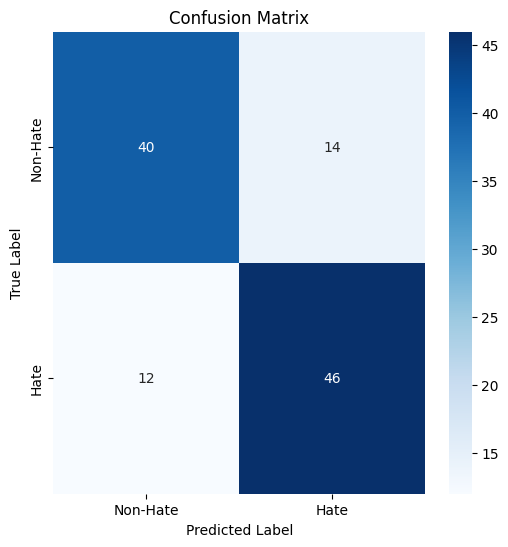

In [113]:
import seaborn as sns

# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['Non-Hate', 'Hate']))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

evaluate_model(model_2, test_features_xlsr_cnn, test_labels_tensor_xlsr_bin)

In [114]:
# Save the trained model
torch.save(model_2.state_dict(), "wav2vec2_bin_CNN_model (TAMIL).pth")
print("Model saved successfully!")

Model saved successfully!


**Multi Classification**

In [41]:
# Update model configuration to set pooling mode and use binary labels
pooling_mode = "mean"  # Using mean pooling for downsampling hidden states
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels_M,
    label2id={label: i for i, label in enumerate(multi_class_label_list)},
    id2label={i: label for i, label in enumerate(multi_class_label_list)},
    finetuning_task="wav2vec2_clf",
) 
setattr(config, 'pooling_mode', pooling_mode)

target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [42]:
# Extract multi-class labels
train_labels_multi = np.array([example['Multi-class Label'] for example in train_dataset])
test_labels_multi = np.array([example['Multi-class Label'] for example in test_dataset]) 

In [43]:
train_features_xlsr, train_labels_tensor_xlsr_multi = prepare_data(train_features_wav2vec2, train_labels_multi, 448, 1, 1024)
test_features_xlsr, test_labels_tensor_xlsr_multi = prepare_data(test_features_wav2vec2, test_labels_multi, 112, 1, 1024)

print(f"Shape of training features: {train_features_xlsr.shape}")
print(f"Number of training labels: {len(train_labels_tensor_xlsr_multi)}")

print(f"Shape of testing features: {test_features_xlsr.shape}")
print(f"Number of testing labels: {len(test_labels_tensor_xlsr_multi)}")

Shape of training features: torch.Size([448, 1, 1024])
Number of training labels: 448
Shape of testing features: torch.Size([112, 1, 1024])
Number of testing labels: 112


In [125]:
# Update the LSTM model for multi-class classification
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters for multi-class classification
input_size = 1024
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(train_labels_multi))  # Set num_classes to the number of unique labels
learning_rate = 0.003
num_epochs = 50
batch_size = 16

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to GPU
train_features_xlsr, train_labels_tensor_xlsr_multi = train_features_xlsr.to(device), train_labels_tensor_xlsr_multi.to(device)
test_features_xlsr, test_labels_tensor_xlsr_multi = test_features_xlsr.to(device), test_labels_tensor_xlsr_multi.to(device)

# Create DataLoader for batching
train_dataset_xlsr_multi_lstm = TensorDataset(train_features_xlsr, train_labels_tensor_xlsr_multi)
train_loader = DataLoader(train_dataset_xlsr_multi_lstm, batch_size=batch_size, shuffle=True)

In [127]:
# Model, Loss, Optimizer with Class Weights
model_3 = AudioLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Use class weights here
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_3, train_loader, optimizer, criterion, num_epochs)

Epoch 1/50: 100%|██████████| 28/28 [00:00<00:00, 207.77batch/s, Batch Loss=1.26]


Epoch [1/50], Average Loss: 1.3732


Epoch 2/50: 100%|██████████| 28/28 [00:00<00:00, 210.07batch/s, Batch Loss=1.21]


Epoch [2/50], Average Loss: 1.3238


Epoch 3/50: 100%|██████████| 28/28 [00:00<00:00, 210.52batch/s, Batch Loss=1.05] 


Epoch [3/50], Average Loss: 1.3080


Epoch 4/50: 100%|██████████| 28/28 [00:00<00:00, 206.30batch/s, Batch Loss=1.3]  


Epoch [4/50], Average Loss: 1.2922


Epoch 5/50: 100%|██████████| 28/28 [00:00<00:00, 191.53batch/s, Batch Loss=0.937]


Epoch [5/50], Average Loss: 1.2908


Epoch 6/50: 100%|██████████| 28/28 [00:00<00:00, 203.16batch/s, Batch Loss=1.14]


Epoch [6/50], Average Loss: 1.2928


Epoch 7/50: 100%|██████████| 28/28 [00:00<00:00, 206.52batch/s, Batch Loss=0.729]


Epoch [7/50], Average Loss: 1.2562


Epoch 8/50: 100%|██████████| 28/28 [00:00<00:00, 209.69batch/s, Batch Loss=1.4] 


Epoch [8/50], Average Loss: 1.2338


Epoch 9/50: 100%|██████████| 28/28 [00:00<00:00, 210.60batch/s, Batch Loss=1.37] 


Epoch [9/50], Average Loss: 1.2764


Epoch 10/50: 100%|██████████| 28/28 [00:00<00:00, 214.48batch/s, Batch Loss=1.32] 


Epoch [10/50], Average Loss: 1.2800


Epoch 11/50: 100%|██████████| 28/28 [00:00<00:00, 212.64batch/s, Batch Loss=1.5]  


Epoch [11/50], Average Loss: 1.2448


Epoch 12/50: 100%|██████████| 28/28 [00:00<00:00, 207.06batch/s, Batch Loss=1.13] 


Epoch [12/50], Average Loss: 1.2141


Epoch 13/50: 100%|██████████| 28/28 [00:00<00:00, 209.11batch/s, Batch Loss=1.22] 


Epoch [13/50], Average Loss: 1.1830


Epoch 14/50: 100%|██████████| 28/28 [00:00<00:00, 206.71batch/s, Batch Loss=1.16] 


Epoch [14/50], Average Loss: 1.1711


Epoch 15/50: 100%|██████████| 28/28 [00:00<00:00, 212.74batch/s, Batch Loss=1.26] 


Epoch [15/50], Average Loss: 1.1432


Epoch 16/50: 100%|██████████| 28/28 [00:00<00:00, 208.71batch/s, Batch Loss=0.756]


Epoch [16/50], Average Loss: 1.1079


Epoch 17/50: 100%|██████████| 28/28 [00:00<00:00, 204.07batch/s, Batch Loss=0.931]


Epoch [17/50], Average Loss: 1.1163


Epoch 18/50: 100%|██████████| 28/28 [00:00<00:00, 209.84batch/s, Batch Loss=1.33] 


Epoch [18/50], Average Loss: 1.1383


Epoch 19/50: 100%|██████████| 28/28 [00:00<00:00, 209.69batch/s, Batch Loss=1.2]  


Epoch [19/50], Average Loss: 1.0990


Epoch 20/50: 100%|██████████| 28/28 [00:00<00:00, 212.85batch/s, Batch Loss=0.756]


Epoch [20/50], Average Loss: 1.0078


Epoch 21/50: 100%|██████████| 28/28 [00:00<00:00, 209.18batch/s, Batch Loss=0.879]


Epoch [21/50], Average Loss: 0.9878


Epoch 22/50: 100%|██████████| 28/28 [00:00<00:00, 207.50batch/s, Batch Loss=0.696]


Epoch [22/50], Average Loss: 0.9890


Epoch 23/50: 100%|██████████| 28/28 [00:00<00:00, 209.05batch/s, Batch Loss=0.806]


Epoch [23/50], Average Loss: 1.0282


Epoch 24/50: 100%|██████████| 28/28 [00:00<00:00, 209.12batch/s, Batch Loss=1.2]  


Epoch [24/50], Average Loss: 0.9653


Epoch 25/50: 100%|██████████| 28/28 [00:00<00:00, 210.69batch/s, Batch Loss=1.03] 


Epoch [25/50], Average Loss: 0.9630


Epoch 26/50: 100%|██████████| 28/28 [00:00<00:00, 209.99batch/s, Batch Loss=0.83] 


Epoch [26/50], Average Loss: 0.9746


Epoch 27/50: 100%|██████████| 28/28 [00:00<00:00, 203.41batch/s, Batch Loss=1.21] 


Epoch [27/50], Average Loss: 0.9532


Epoch 28/50: 100%|██████████| 28/28 [00:00<00:00, 207.32batch/s, Batch Loss=0.796]


Epoch [28/50], Average Loss: 0.9076


Epoch 29/50: 100%|██████████| 28/28 [00:00<00:00, 190.11batch/s, Batch Loss=0.948]


Epoch [29/50], Average Loss: 0.9285


Epoch 30/50: 100%|██████████| 28/28 [00:00<00:00, 190.79batch/s, Batch Loss=0.907]


Epoch [30/50], Average Loss: 0.9274


Epoch 31/50: 100%|██████████| 28/28 [00:00<00:00, 183.94batch/s, Batch Loss=0.704]


Epoch [31/50], Average Loss: 0.8525


Epoch 32/50: 100%|██████████| 28/28 [00:00<00:00, 183.79batch/s, Batch Loss=1.31] 


Epoch [32/50], Average Loss: 0.9462


Epoch 33/50: 100%|██████████| 28/28 [00:00<00:00, 192.03batch/s, Batch Loss=0.863]


Epoch [33/50], Average Loss: 0.9059


Epoch 34/50: 100%|██████████| 28/28 [00:00<00:00, 197.04batch/s, Batch Loss=1.05] 


Epoch [34/50], Average Loss: 0.9262


Epoch 35/50: 100%|██████████| 28/28 [00:00<00:00, 179.31batch/s, Batch Loss=0.528]


Epoch [35/50], Average Loss: 0.8884


Epoch 36/50: 100%|██████████| 28/28 [00:00<00:00, 204.89batch/s, Batch Loss=0.671]


Epoch [36/50], Average Loss: 0.8805


Epoch 37/50: 100%|██████████| 28/28 [00:00<00:00, 196.34batch/s, Batch Loss=1.15] 


Epoch [37/50], Average Loss: 0.8802


Epoch 38/50: 100%|██████████| 28/28 [00:00<00:00, 189.64batch/s, Batch Loss=0.475]


Epoch [38/50], Average Loss: 0.9051


Epoch 39/50: 100%|██████████| 28/28 [00:00<00:00, 200.60batch/s, Batch Loss=0.635]


Epoch [39/50], Average Loss: 0.8613


Epoch 40/50: 100%|██████████| 28/28 [00:00<00:00, 211.39batch/s, Batch Loss=1.2]  


Epoch [40/50], Average Loss: 0.8690


Epoch 41/50: 100%|██████████| 28/28 [00:00<00:00, 207.91batch/s, Batch Loss=1.06] 


Epoch [41/50], Average Loss: 0.9487


Epoch 42/50: 100%|██████████| 28/28 [00:00<00:00, 209.53batch/s, Batch Loss=0.95] 


Epoch [42/50], Average Loss: 0.8559


Epoch 43/50: 100%|██████████| 28/28 [00:00<00:00, 209.42batch/s, Batch Loss=0.899]


Epoch [43/50], Average Loss: 0.8714


Epoch 44/50: 100%|██████████| 28/28 [00:00<00:00, 206.75batch/s, Batch Loss=0.813]


Epoch [44/50], Average Loss: 0.9003


Epoch 45/50: 100%|██████████| 28/28 [00:00<00:00, 208.58batch/s, Batch Loss=0.719]


Epoch [45/50], Average Loss: 0.8333


Epoch 46/50: 100%|██████████| 28/28 [00:00<00:00, 209.22batch/s, Batch Loss=1.05] 


Epoch [46/50], Average Loss: 0.8754


Epoch 47/50: 100%|██████████| 28/28 [00:00<00:00, 211.82batch/s, Batch Loss=0.774]


Epoch [47/50], Average Loss: 0.8408


Epoch 48/50: 100%|██████████| 28/28 [00:00<00:00, 207.45batch/s, Batch Loss=0.749]


Epoch [48/50], Average Loss: 0.8561


Epoch 49/50: 100%|██████████| 28/28 [00:00<00:00, 211.93batch/s, Batch Loss=0.751]


Epoch [49/50], Average Loss: 0.8691


Epoch 50/50: 100%|██████████| 28/28 [00:00<00:00, 206.76batch/s, Batch Loss=0.699]

Epoch [50/50], Average Loss: 0.8008


              precision    recall  f1-score   support

           C       0.33      0.43      0.38        14
           G       0.38      0.13      0.19        23
           P       0.67      0.20      0.31        10
           R       0.38      0.82      0.51        11
    Non Hate       0.73      0.80      0.76        54

    accuracy                           0.56       112
   macro avg       0.50      0.47      0.43       112
weighted avg       0.57      0.56      0.53       112



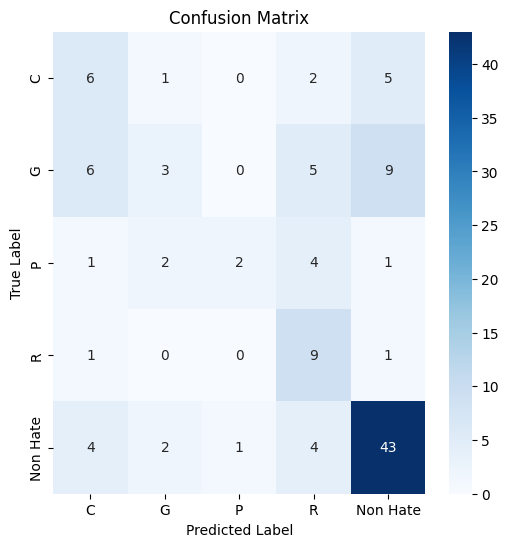

In [128]:
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['C','G','P','R','Non Hate'], zero_division=1))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['C','G','P','R','Non Hate'], yticklabels=['C','G','P','R','Non Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

# Testing
evaluate_model(model_3, test_features_xlsr, test_labels_tensor_xlsr_multi)

In [129]:
# Save the trained model
torch.save(model_3.state_dict(), "wav2vec2_multi_LSTM_model (TAMIL).pth")
print("Model saved successfully!")

Model saved successfully!


In [166]:
# Define the 1D CNN model for multi-class classification
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for multi-class
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.mean(dim=2)  # Global average pooling across the sequence
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
num_classes = len(set(train_dataset['Multi-class Label']))  # The number of classes from your dataset
learning_rate = 0.002
num_epochs = 50
batch_size = 16

In [167]:
# Reshape features for CNN
train_features_xlsr_multi_cnn = train_features_xlsr.permute(0, 2, 1).to(device)  # Shape to [batch, 1024, 1]
test_features_xlsr_multi_cnn = test_features_xlsr.permute(0, 2, 1).to(device)

train_dataset_cnn_multi = TensorDataset(train_features_xlsr_multi_cnn, train_labels_tensor_xlsr_multi)
train_loader = DataLoader(train_dataset_cnn_multi, batch_size=batch_size, shuffle=True)

In [168]:
# Model, Loss, Optimizer
model_cnn_multi = AudioCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_multi.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Run training and evaluation
train_model(model_cnn_multi, train_loader, optimizer, criterion, num_epochs)

Epoch 1/50: 100%|██████████| 28/28 [00:00<00:00, 257.94batch/s, Batch Loss=1.39]


Epoch [1/50], Average Loss: 1.4233


Epoch 2/50: 100%|██████████| 28/28 [00:00<00:00, 265.91batch/s, Batch Loss=1.43]


Epoch [2/50], Average Loss: 1.3183


Epoch 3/50: 100%|██████████| 28/28 [00:00<00:00, 268.02batch/s, Batch Loss=1.45]


Epoch [3/50], Average Loss: 1.3117


Epoch 4/50: 100%|██████████| 28/28 [00:00<00:00, 262.04batch/s, Batch Loss=1.4] 


Epoch [4/50], Average Loss: 1.3086


Epoch 5/50: 100%|██████████| 28/28 [00:00<00:00, 273.55batch/s, Batch Loss=1.2] 


Epoch [5/50], Average Loss: 1.2911


Epoch 6/50: 100%|██████████| 28/28 [00:00<00:00, 283.66batch/s, Batch Loss=1.44] 


Epoch [6/50], Average Loss: 1.2825


Epoch 7/50: 100%|██████████| 28/28 [00:00<00:00, 281.89batch/s, Batch Loss=1.28] 


Epoch [7/50], Average Loss: 1.2812


Epoch 8/50: 100%|██████████| 28/28 [00:00<00:00, 275.11batch/s, Batch Loss=1.2]  


Epoch [8/50], Average Loss: 1.2745


Epoch 9/50: 100%|██████████| 28/28 [00:00<00:00, 287.50batch/s, Batch Loss=1.55] 


Epoch [9/50], Average Loss: 1.2492


Epoch 10/50: 100%|██████████| 28/28 [00:00<00:00, 273.46batch/s, Batch Loss=1.5] 


Epoch [10/50], Average Loss: 1.2593


Epoch 11/50: 100%|██████████| 28/28 [00:00<00:00, 284.55batch/s, Batch Loss=1.39]


Epoch [11/50], Average Loss: 1.2661


Epoch 12/50: 100%|██████████| 28/28 [00:00<00:00, 284.56batch/s, Batch Loss=1.46] 


Epoch [12/50], Average Loss: 1.2898


Epoch 13/50: 100%|██████████| 28/28 [00:00<00:00, 279.05batch/s, Batch Loss=0.853]


Epoch [13/50], Average Loss: 1.2475


Epoch 14/50: 100%|██████████| 28/28 [00:00<00:00, 283.08batch/s, Batch Loss=1.68] 


Epoch [14/50], Average Loss: 1.2065


Epoch 15/50: 100%|██████████| 28/28 [00:00<00:00, 284.04batch/s, Batch Loss=1.13] 


Epoch [15/50], Average Loss: 1.1782


Epoch 16/50: 100%|██████████| 28/28 [00:00<00:00, 284.62batch/s, Batch Loss=1.05] 


Epoch [16/50], Average Loss: 1.1053


Epoch 17/50: 100%|██████████| 28/28 [00:00<00:00, 281.08batch/s, Batch Loss=1.01] 


Epoch [17/50], Average Loss: 1.1317


Epoch 18/50: 100%|██████████| 28/28 [00:00<00:00, 279.38batch/s, Batch Loss=0.958]


Epoch [18/50], Average Loss: 1.1380


Epoch 19/50: 100%|██████████| 28/28 [00:00<00:00, 281.26batch/s, Batch Loss=1.06] 


Epoch [19/50], Average Loss: 1.0919


Epoch 20/50: 100%|██████████| 28/28 [00:00<00:00, 283.15batch/s, Batch Loss=1.36] 


Epoch [20/50], Average Loss: 1.1248


Epoch 21/50: 100%|██████████| 28/28 [00:00<00:00, 283.76batch/s, Batch Loss=0.978]


Epoch [21/50], Average Loss: 1.0349


Epoch 22/50: 100%|██████████| 28/28 [00:00<00:00, 281.34batch/s, Batch Loss=0.717]


Epoch [22/50], Average Loss: 1.0071


Epoch 23/50: 100%|██████████| 28/28 [00:00<00:00, 283.85batch/s, Batch Loss=1.99] 


Epoch [23/50], Average Loss: 1.0062


Epoch 24/50: 100%|██████████| 28/28 [00:00<00:00, 281.85batch/s, Batch Loss=0.808]


Epoch [24/50], Average Loss: 1.0612


Epoch 25/50: 100%|██████████| 28/28 [00:00<00:00, 280.08batch/s, Batch Loss=1.13] 


Epoch [25/50], Average Loss: 1.0176


Epoch 26/50: 100%|██████████| 28/28 [00:00<00:00, 272.46batch/s, Batch Loss=1.14] 


Epoch [26/50], Average Loss: 0.9981


Epoch 27/50: 100%|██████████| 28/28 [00:00<00:00, 285.03batch/s, Batch Loss=0.976]


Epoch [27/50], Average Loss: 0.9778


Epoch 28/50: 100%|██████████| 28/28 [00:00<00:00, 277.57batch/s, Batch Loss=0.887]


Epoch [28/50], Average Loss: 1.0161


Epoch 29/50: 100%|██████████| 28/28 [00:00<00:00, 274.23batch/s, Batch Loss=1.42] 


Epoch [29/50], Average Loss: 1.0382


Epoch 30/50: 100%|██████████| 28/28 [00:00<00:00, 270.60batch/s, Batch Loss=0.969]


Epoch [30/50], Average Loss: 1.0322


Epoch 31/50: 100%|██████████| 28/28 [00:00<00:00, 270.62batch/s, Batch Loss=1.07] 


Epoch [31/50], Average Loss: 0.9428


Epoch 32/50: 100%|██████████| 28/28 [00:00<00:00, 278.82batch/s, Batch Loss=0.875]


Epoch [32/50], Average Loss: 0.9491


Epoch 33/50: 100%|██████████| 28/28 [00:00<00:00, 280.28batch/s, Batch Loss=0.809]


Epoch [33/50], Average Loss: 1.0202


Epoch 34/50: 100%|██████████| 28/28 [00:00<00:00, 283.80batch/s, Batch Loss=0.917]


Epoch [34/50], Average Loss: 1.0395


Epoch 35/50: 100%|██████████| 28/28 [00:00<00:00, 281.41batch/s, Batch Loss=0.949]


Epoch [35/50], Average Loss: 0.9115


Epoch 36/50: 100%|██████████| 28/28 [00:00<00:00, 275.56batch/s, Batch Loss=1.05] 


Epoch [36/50], Average Loss: 1.1178


Epoch 37/50: 100%|██████████| 28/28 [00:00<00:00, 280.43batch/s, Batch Loss=0.916]


Epoch [37/50], Average Loss: 0.9667


Epoch 38/50: 100%|██████████| 28/28 [00:00<00:00, 282.13batch/s, Batch Loss=1.03] 


Epoch [38/50], Average Loss: 0.9127


Epoch 39/50: 100%|██████████| 28/28 [00:00<00:00, 272.45batch/s, Batch Loss=1.13] 


Epoch [39/50], Average Loss: 0.9010


Epoch 40/50: 100%|██████████| 28/28 [00:00<00:00, 278.48batch/s, Batch Loss=1.16] 


Epoch [40/50], Average Loss: 0.9360


Epoch 41/50: 100%|██████████| 28/28 [00:00<00:00, 280.76batch/s, Batch Loss=0.733]


Epoch [41/50], Average Loss: 0.9064


Epoch 42/50: 100%|██████████| 28/28 [00:00<00:00, 282.53batch/s, Batch Loss=0.788]


Epoch [42/50], Average Loss: 0.8752


Epoch 43/50: 100%|██████████| 28/28 [00:00<00:00, 274.88batch/s, Batch Loss=0.721]


Epoch [43/50], Average Loss: 0.9195


Epoch 44/50: 100%|██████████| 28/28 [00:00<00:00, 266.39batch/s, Batch Loss=0.736]


Epoch [44/50], Average Loss: 0.9159


Epoch 45/50: 100%|██████████| 28/28 [00:00<00:00, 279.46batch/s, Batch Loss=1.06] 


Epoch [45/50], Average Loss: 0.8742


Epoch 46/50: 100%|██████████| 28/28 [00:00<00:00, 274.30batch/s, Batch Loss=0.711]


Epoch [46/50], Average Loss: 0.8551


Epoch 47/50: 100%|██████████| 28/28 [00:00<00:00, 275.71batch/s, Batch Loss=0.774]


Epoch [47/50], Average Loss: 0.8654


Epoch 48/50: 100%|██████████| 28/28 [00:00<00:00, 273.05batch/s, Batch Loss=1.28] 


Epoch [48/50], Average Loss: 0.8372


Epoch 49/50: 100%|██████████| 28/28 [00:00<00:00, 269.69batch/s, Batch Loss=0.456]


Epoch [49/50], Average Loss: 0.8849


Epoch 50/50: 100%|██████████| 28/28 [00:00<00:00, 269.52batch/s, Batch Loss=0.809]


Epoch [50/50], Average Loss: 0.9084


              precision    recall  f1-score   support

           C       0.14      0.07      0.10        14
           G       1.00      0.00      0.00        23
           P       1.00      0.00      0.00        10
           R       0.31      0.82      0.45        11
    Non Hate       0.62      0.87      0.72        54

    accuracy                           0.51       112
   macro avg       0.61      0.35      0.25       112
weighted avg       0.64      0.51      0.40       112



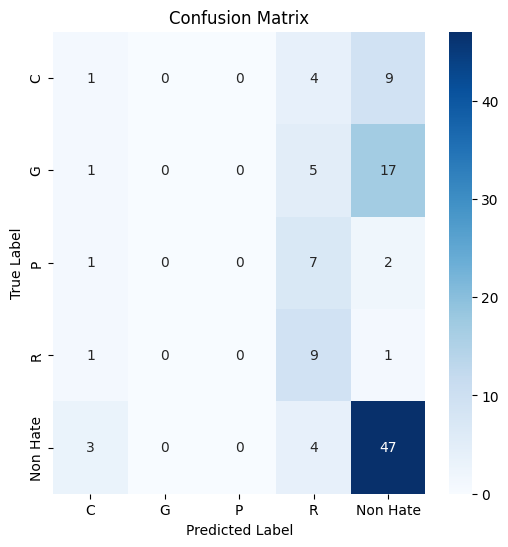

In [169]:
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['C','G','P','R','Non Hate'], zero_division=1))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['C','G','P','R','Non Hate'], yticklabels=['C','G','P','R','Non Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

evaluate_model(model_cnn_multi, test_features_xlsr_multi_cnn, test_labels_tensor_xlsr_multi)

In [170]:
# Save the trained model
torch.save(model_cnn_multi.state_dict(), "wav2vec2_multi_CNN_model.pth")
print("Model saved successfully!")

Model saved successfully!


# **Indic-Wav2Vec2**

In [171]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")

# Initialize the processor for Wav2Vec2
#processor = Wav2Vec2Processor.from_pretrained("superb/wav2vec2-base-superb-er")

# Load the model with ignore_mismatched_sizes=True to handle custom label size
model_indic = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-er",
    num_labels=2,  # Set for binary classification
    ignore_mismatched_sizes=True  # Adjust layer sizes for mismatches
) 

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:  50%|####9     | 189M/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [172]:
def load_audio_data(dataset, target_length=16000*10):  # Default: 60 seconds
    audio_inputs = []
    labels = []
    
    for row in dataset:
        audio_path = row['New File Path']
        label = row['Binary Label']
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Resample if needed
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
             
        # If the waveform is longer than target_length, truncate it
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        # If the waveform is shorter, pad it with zeros
        elif waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # **Fix the shape issue**
        audio_inputs.append(waveform.squeeze(0))  # Ensure shape [sequence_length]
        labels.append(label)

    return torch.stack(audio_inputs), torch.tensor(labels)

# Load train and test data with a fixed target length
train_inputs, train_labels = load_audio_data(train_dataset)
test_inputs, test_labels = load_audio_data(test_dataset)

print(f"Train inputs shape: {train_inputs.shape}")  # Now they should all be the same length

Train inputs shape: torch.Size([448, 160000])


In [173]:
# Save extracted features
torch.save(train_inputs, "indic_wav2vec_train_features.pt")
torch.save(test_inputs, "indic_wav2vec_test_features.pt")

# Save labels
torch.save(train_labels, "indic_wav2vec_train_labels.pt")
torch.save(test_labels, "indic_wav2vec_test_labels.pt")

print("Extracted features and labels saved successfully!")

Extracted features and labels saved successfully!


In [174]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader_indic_wav2 = DataLoader(list(zip(train_inputs, train_labels)), batch_size=16, shuffle=True)
test_loader_indic_wav2 = DataLoader(list(zip(test_inputs, test_labels)), batch_size=16, shuffle=False)

In [175]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")


Using GPU: Tesla T4


In [176]:
from tqdm import tqdm

# Set optimizer
optimizer = torch.optim.AdamW(model_indic.parameters(), lr=1e-5)

# Move model to GPU
model_indic.to(device)

# Training loop
model_indic.train()
num_epochs = 15
for epoch in range(num_epochs):  # Number of epochs
    # Create a progress bar for the training data
    with tqdm(total=len(train_loader_indic_wav2), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader_indic_wav2:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU

            optimizer.zero_grad()  # Reset gradients
            outputs = model_indic(inputs).logits  # Forward pass
            loss = torch.nn.functional.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            pbar.set_postfix(loss=loss.item())  # Update progress bar with current loss
            pbar.update(1)  # Increment the progress bar
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')  # Print the loss for the epoch

Epoch 1/15: 100%|██████████| 28/28 [01:39<00:00,  3.55s/batch, loss=0.636]


Epoch 1/15, Loss: 0.6358180046081543


Epoch 2/15: 100%|██████████| 28/28 [01:38<00:00,  3.52s/batch, loss=0.392]


Epoch 2/15, Loss: 0.3915514647960663


Epoch 3/15: 100%|██████████| 28/28 [01:39<00:00,  3.57s/batch, loss=0.455]


Epoch 3/15, Loss: 0.45462775230407715


Epoch 4/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=0.263]


Epoch 4/15, Loss: 0.2625361680984497


Epoch 5/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=0.22] 


Epoch 5/15, Loss: 0.21976299583911896


Epoch 6/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=0.246]


Epoch 6/15, Loss: 0.24588266015052795


Epoch 7/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=0.239]


Epoch 7/15, Loss: 0.23874354362487793


Epoch 8/15: 100%|██████████| 28/28 [01:39<00:00,  3.57s/batch, loss=0.0794]


Epoch 8/15, Loss: 0.07940739393234253


Epoch 9/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=0.234] 


Epoch 9/15, Loss: 0.2340136170387268


Epoch 10/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=0.315] 


Epoch 10/15, Loss: 0.31462526321411133


Epoch 11/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=0.257] 


Epoch 11/15, Loss: 0.25670382380485535


Epoch 12/15: 100%|██████████| 28/28 [01:38<00:00,  3.52s/batch, loss=0.107] 


Epoch 12/15, Loss: 0.10682041198015213


Epoch 13/15: 100%|██████████| 28/28 [01:40<00:00,  3.58s/batch, loss=0.0376]


Epoch 13/15, Loss: 0.03760542348027229


Epoch 14/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=0.252] 


Epoch 14/15, Loss: 0.2523341774940491


Epoch 15/15: 100%|██████████| 28/28 [01:38<00:00,  3.51s/batch, loss=0.0137]

Epoch 15/15, Loss: 0.01371136587113142


In [177]:
from tqdm import tqdm

# Set the model to evaluation mode
model_indic.eval()

# Store predictions and true labels
all_predictions = []
all_labels = []

# Testing loop
with torch.no_grad():  # Disable gradient calculation for evaluation
    with tqdm(total=len(test_loader_indic_wav2), desc='Testing', unit='batch') as pbar:
        for batch in test_loader_indic_wav2:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU
            
            # Forward pass
            outputs = model_indic(inputs).logits  # Get logits from the model
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            pbar.update(1)  # Increment the progress bar

# After the testing loop, you can evaluate your model's performance
# You can calculate accuracy or any other metrics you prefer
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optionally, you can also print a classification report
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions))

Testing: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s]

Accuracy: 82.14%
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        54
           1       0.95      0.69      0.80        58

    accuracy                           0.82       112
   macro avg       0.85      0.83      0.82       112
weighted avg       0.85      0.82      0.82       112



Confusion Matrix:
[[52  2]
 [18 40]]


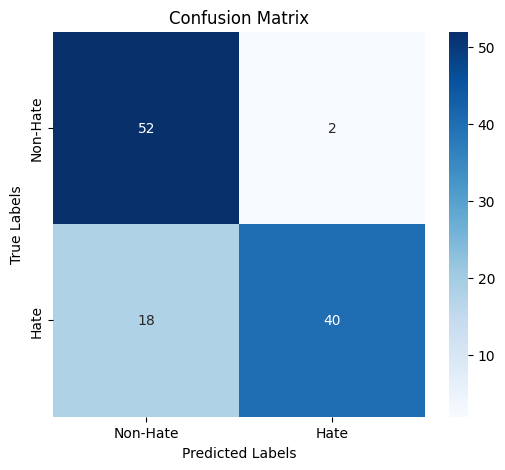

In [178]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [179]:
# Save the trained model
torch.save(model_indic.state_dict(), "indic_wav2vec_binary.pth")
print("Model saved successfully!")

Model saved successfully!


**Multi-class classification**

In [180]:
# Load the model with the number of labels set for multi-class classification
model_multi_indic = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-er",
    num_labels=len(train_dataset.unique('Multi-class Label')),  # Set for multi-class classification
    ignore_mismatched_sizes=True  # Adjust layer sizes for mismatches
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [181]:
def load_audio_data_multi(dataset, target_length=16000*10):  # e.g., 10 seconds for a fixed length
    audio_inputs_multi = []
    multi_class_labels = []
    
    for row in dataset:
        audio_path = row['New File Path']
        label = row['Multi-class Label']  # Change to multi-class label
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Resample if needed
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        
        # If the waveform is longer than target_length, truncate it
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        # If the waveform is shorter, pad it with zeros
        elif waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        audio_inputs_multi.append(waveform.squeeze(0))  # Remove the channel dimension
        multi_class_labels.append(label)

    return torch.stack(audio_inputs_multi), torch.tensor(multi_class_labels)

# Load train and test data for multi-class classification
train_inputs_multi, train_labels_multi = load_audio_data_multi(train_dataset)
test_inputs_multi, test_labels_multi = load_audio_data_multi(test_dataset)

print(f"Train inputs shape for multi-class: {train_inputs_multi.shape}")  # Now they should all be the same length

Train inputs shape for multi-class: torch.Size([448, 160000])


In [182]:
# Save extracted features
torch.save(train_inputs_multi, "indic_wav2vec_multi_train_features.pt")
torch.save(test_inputs_multi, "indic_wav2vec_multi_test_features.pt")

# Save labels
torch.save(train_labels_multi, "indic_wav2vec_multi_train_labels.pt")
torch.save(test_labels_multi, "indic_wav2vec_multi_test_labels.pt")

print("Extracted features and labels saved successfully!")

Extracted features and labels saved successfully!


In [183]:
# Create DataLoaders for multi-class classification
train_loader_multi_indic = DataLoader(list(zip(train_inputs_multi, train_labels_multi)), batch_size=16, shuffle=True)
test_loader_multi_indic = DataLoader(list(zip(test_inputs_multi, test_labels_multi)), batch_size=16, shuffle=False)

In [184]:
# Set optimizer for multi-class classification
optimizer_multi = torch.optim.AdamW(model_multi_indic.parameters(), lr=1e-5)

# Move model to GPU
model_multi_indic.to(device)

# Training loop for multi-class classification
model_multi_indic.train()
num_epochs_multi = 15
for epoch in range(num_epochs_multi):  # Number of epochs 
    # Create a progress bar for the training data
    with tqdm(total=len(train_loader_multi_indic), desc=f'Epoch {epoch + 1}/{num_epochs_multi}', unit='batch') as pbar:
        for batch in train_loader_multi_indic:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU

            optimizer_multi.zero_grad()  # Reset gradients
            outputs = model_multi_indic(inputs).logits  # Forward pass
            loss = torch.nn.functional.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer_multi.step()  # Update weights
            
            pbar.set_postfix(loss=loss.item())  # Update progress bar with current loss
            pbar.update(1)  # Increment the progress bar
    print(f'Epoch {epoch + 1}/{num_epochs_multi}, Loss: {loss.item()}')  # Print the loss for the epoch

Epoch 1/15: 100%|██████████| 28/28 [01:39<00:00,  3.57s/batch, loss=1.36]


Epoch 1/15, Loss: 1.3590466976165771


Epoch 2/15: 100%|██████████| 28/28 [01:39<00:00,  3.55s/batch, loss=1.74] 


Epoch 2/15, Loss: 1.7362949848175049


Epoch 3/15: 100%|██████████| 28/28 [01:40<00:00,  3.59s/batch, loss=1.06] 


Epoch 3/15, Loss: 1.0586191415786743


Epoch 4/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=1.05] 


Epoch 4/15, Loss: 1.047597885131836


Epoch 5/15: 100%|██████████| 28/28 [01:39<00:00,  3.55s/batch, loss=1.26] 


Epoch 5/15, Loss: 1.2570432424545288


Epoch 6/15: 100%|██████████| 28/28 [01:39<00:00,  3.56s/batch, loss=1.37] 


Epoch 6/15, Loss: 1.3659669160842896


Epoch 7/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=1.02] 


Epoch 7/15, Loss: 1.0187488794326782


Epoch 8/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=0.97] 


Epoch 8/15, Loss: 0.9699504971504211


Epoch 9/15: 100%|██████████| 28/28 [01:37<00:00,  3.47s/batch, loss=0.637]


Epoch 9/15, Loss: 0.6374833583831787


Epoch 10/15: 100%|██████████| 28/28 [01:40<00:00,  3.60s/batch, loss=0.787]


Epoch 10/15, Loss: 0.7874120473861694


Epoch 11/15: 100%|██████████| 28/28 [01:39<00:00,  3.54s/batch, loss=0.776]


Epoch 11/15, Loss: 0.7758059501647949


Epoch 12/15: 100%|██████████| 28/28 [01:38<00:00,  3.53s/batch, loss=0.969]


Epoch 12/15, Loss: 0.9688579440116882


Epoch 13/15: 100%|██████████| 28/28 [01:39<00:00,  3.55s/batch, loss=0.928]


Epoch 13/15, Loss: 0.9278272986412048


Epoch 14/15: 100%|██████████| 28/28 [01:39<00:00,  3.55s/batch, loss=0.606]


Epoch 14/15, Loss: 0.6063750982284546


Epoch 15/15: 100%|██████████| 28/28 [01:39<00:00,  3.54s/batch, loss=1.08] 

Epoch 15/15, Loss: 1.0816495418548584


Testing: 100%|██████████| 7/7 [00:05<00:00,  1.24batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multi-class Accuracy: 56.25%
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.29      0.30        14
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        10
           3       0.40      0.73      0.52        11
           4       0.65      0.94      0.77        54

    accuracy                           0.56       112
   macro avg       0.27      0.39      0.32       112
weighted avg       0.39      0.56      0.46       112



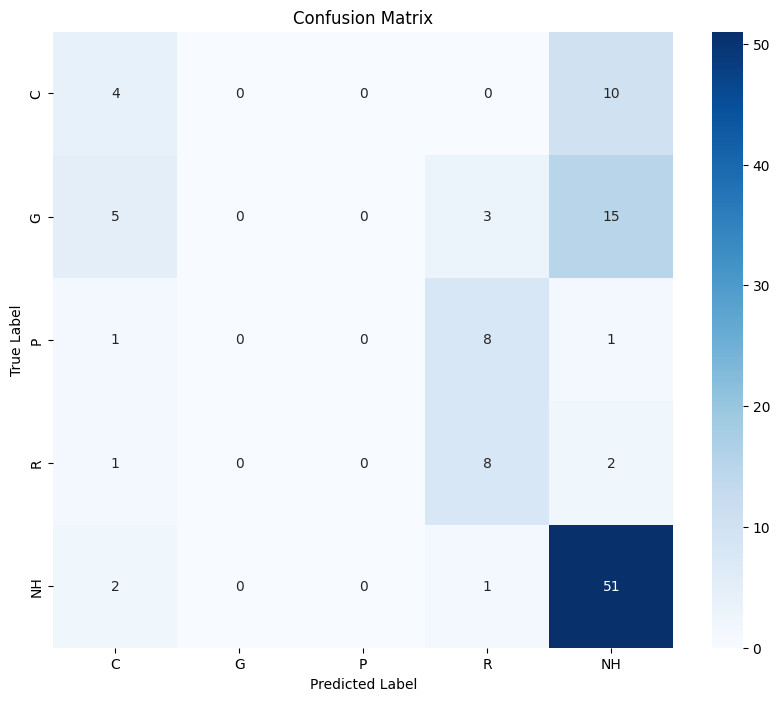

In [185]:
# Set the model to evaluation mode for multi-class classification
model_multi_indic.eval()

# Store predictions and true labels
all_predictions_multi = []
all_labels_multi = []

# Testing loop for multi-class classification
with torch.no_grad():  # Disable gradient calculation for evaluation
    with tqdm(total=len(test_loader_multi_indic), desc='Testing', unit='batch') as pbar:
        for batch in test_loader_multi_indic:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU
            
            # Forward pass
            outputs = model_multi_indic(inputs).logits  # Get logits from the model
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
            
            # Store predictions and labels
            all_predictions_multi.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels_multi.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            pbar.update(1)  # Increment the progress bar

# Calculate accuracy for multi-class classification
accuracy_multi = accuracy_score(all_labels_multi, all_predictions_multi)
print(f'Multi-class Accuracy: {accuracy_multi * 100:.2f}%')

# Print a classification report for multi-class classification
print("Classification Report:")
print(classification_report(all_labels_multi, all_predictions_multi))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels_multi, all_predictions_multi)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels= ['C','G','P','R','NH'], yticklabels=['C','G','P','R','NH'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [186]:
# Save the trained model
torch.save(model_multi_indic.state_dict(), "indic_wav2vec_multi.pth")
print("Model saved successfully!")

Model saved successfully!


# **AST**

In [187]:
from transformers import AutoProcessor, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [188]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("audio-classification", model="MIT/ast-finetuned-audioset-10-10-0.4593", device=0)

# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model_ast = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Device set to use cuda:0


In [189]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ast = model_ast.to(device)  # Move model to GPU

In [190]:
def preprocess_function(example):
    # Load the audio file and resample if necessary
    audio_path = example["New File Path"]
    audio_data, sampling_rate = librosa.load(audio_path, sr=16000)  # AST expects 16kHz
    inputs = extractor(audio_data, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs["labels"] = example["Binary Label"]  # or "Multi-class Label" for multi-class classification
    return inputs

# Map the preprocessing function to the dataset
train_dataset_ast = train_dataset.map(preprocess_function)
test_dataset_ast = test_dataset.map(preprocess_function)

# Data Collator and Trainer Setup
def data_collator(features):
    input_values = [torch.tensor(f["input_values"]).squeeze() for f in features]
    labels = [f["labels"] for f in features]
    
    # Stack inputs and labels into a batch
    batch = {
        "input_values": torch.stack(input_values),
        "labels": torch.tensor(labels),
    }
    return batch

Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [191]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision training for speed
    report_to=[],  # Disable wandb and other logging integrations
    dataloader_pin_memory=False,  # disable pin_memory
)


# Initialize Trainer
trainer = Trainer(
    model=model_ast,
    args=training_args,
    train_dataset=train_dataset_ast,
    eval_dataset=test_dataset_ast,
    data_collator=data_collator,
    tokenizer=extractor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-191-abe0ec37943f>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.404083
2,No log,0.358818
3,No log,0.353687
4,No log,0.525445
5,No log,0.800207
6,No log,1.223845
7,No log,1.506492
8,No log,1.686076
9,No log,1.660678
10,No log,1.707500


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=280, training_loss=0.11806561606270927, metrics={'train_runtime': 1188.723, 'train_samples_per_second': 3.769, 'train_steps_per_second': 0.236, 'total_flos': 3.050895328464077e+17, 'train_loss': 0.11806561606270927, 'epoch': 10.0})

In [192]:
trainer.evaluate()

{'eval_loss': 1.7074997425079346,
 'eval_runtime': 13.3364,
 'eval_samples_per_second': 8.398,
 'eval_steps_per_second': 0.525,
 'epoch': 10.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        54
           1       0.88      0.86      0.87        58

    accuracy                           0.87       112
   macro avg       0.87      0.87      0.87       112
weighted avg       0.87      0.87      0.87       112

Confusion Matrix:


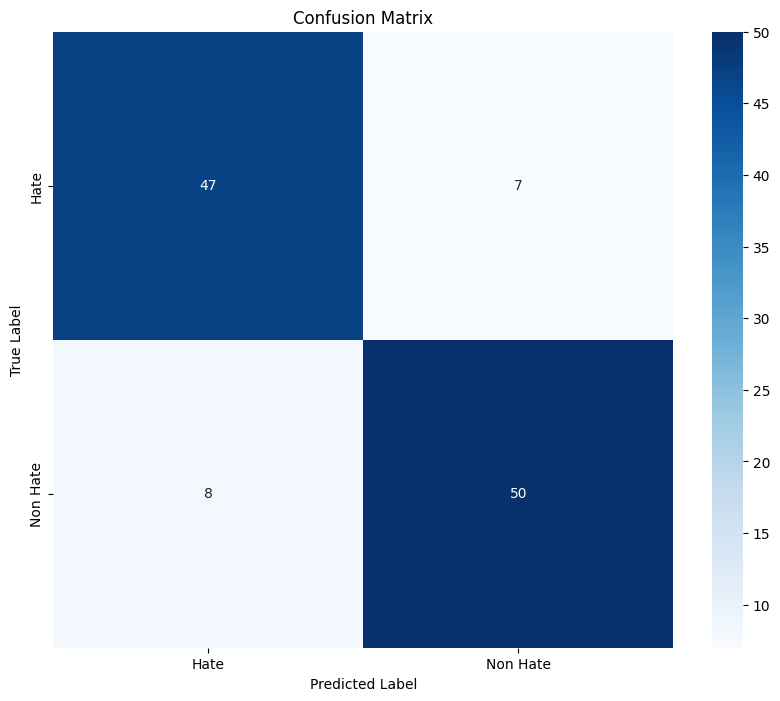

In [193]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Make predictions on the test set
predictions = trainer.predict(test_dataset_ast)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Get predicted labels
true_labels = predictions.label_ids  # True labels

# Step 2: Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# Step 3: Print Confusion Matrix
print("Confusion Matrix:")
c_mat = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", xticklabels= ['Hate', 'Non Hate'], yticklabels= ['Hate', 'Non Hate'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [194]:
def preprocess_function_multi(example):
    # Load the audio file and resample if necessary
    audio_path = example["New File Path"]
    audio_data, sampling_rate = librosa.load(audio_path, sr=16000)  # AST expects 16kHz
    inputs = extractor(audio_data, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs["labels"] = example["Multi-class Label"]  # or "Multi-class Label" for multi-class classification
    return inputs

# Map the preprocessing function to the dataset
train_dataset_ast_multi = train_dataset.map(preprocess_function_multi)
test_dataset_ast_multi = test_dataset.map(preprocess_function_multi)

# Data Collator and Trainer Setup
def data_collator(features):
    input_values = [torch.tensor(f["input_values"]).squeeze() for f in features]
    labels = [f["labels"] for f in features]
    
    # Stack inputs and labels into a batch
    batch = {
        "input_values": torch.stack(input_values),
        "labels": torch.tensor(labels),
    }
    return batch

Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [195]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    #fp16=True,  # Enable mixed precision training for speed
    report_to=[],  # Disable wandb and other logging integrations
    dataloader_pin_memory=False,  # disable pin_memory
)

# Initialize Trainer
trainer_multi = Trainer(
    model=model_ast,
    args=training_args,
    train_dataset=train_dataset_ast_multi,
    eval_dataset=test_dataset_ast_multi,
    data_collator=data_collator,
    tokenizer=extractor,
)

trainer_multi.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-195-4924f224a61f>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_multi = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.235993
2,No log,0.921192
3,No log,1.025513
4,No log,1.164496
5,No log,1.050423
6,No log,1.412003
7,No log,1.974129
8,No log,1.770114
9,No log,2.175453
10,No log,2.344884


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=280, training_loss=0.5497284480503627, metrics={'train_runtime': 1164.082, 'train_samples_per_second': 3.849, 'train_steps_per_second': 0.241, 'total_flos': 3.050895328464077e+17, 'train_loss': 0.5497284480503627, 'epoch': 10.0})

In [196]:
trainer_multi.evaluate()

{'eval_loss': 2.344884157180786,
 'eval_runtime': 13.0919,
 'eval_samples_per_second': 8.555,
 'eval_steps_per_second': 0.535,
 'epoch': 10.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.64      0.51        14
           1       0.83      0.22      0.34        23
           2       1.00      0.80      0.89        10
           3       0.50      0.73      0.59        11
           4       0.84      0.94      0.89        54

    accuracy                           0.72       112
   macro avg       0.72      0.67      0.65       112
weighted avg       0.77      0.72      0.70       112

Confusion Matrix:


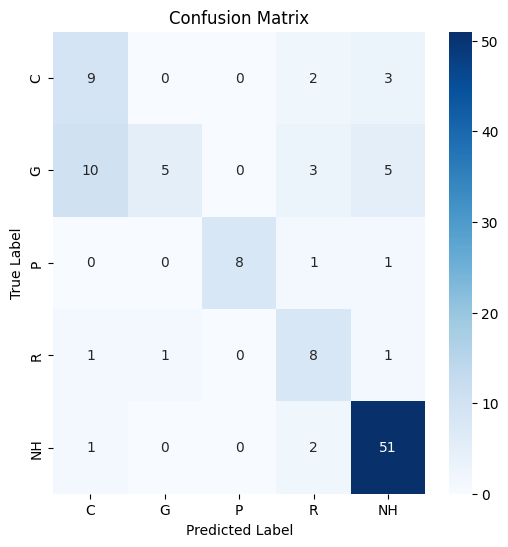

In [197]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
predictions_multi = trainer_multi.predict(test_dataset_ast_multi)
pred_labels_multi = np.argmax(predictions_multi.predictions, axis=1)  # Get predicted labels
true_labels_multi = predictions_multi.label_ids  # True labels

# Step 2: Print Classification Report
print("Classification Report:")
print(classification_report(true_labels_multi, pred_labels_multi))

# Step 3: Print Confusion Matrix
print("Confusion Matrix:")
c_mat = confusion_matrix(true_labels_multi, pred_labels_multi)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", xticklabels= ['C','G','P','R','NH'], yticklabels= ['C','G','P','R','NH'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()